In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
import matplotlib as mpl

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [13]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [18]:
def get_pos_vel_mass_halo_bulge(sn, gas=False, center=np.array([0., 0., 0.])):
    pos_halo = sn.part1.pos.value[np.argsort(sn.part1.id)]
    vel_halo = sn.part1.vel.value[np.argsort(sn.part1.id)]
    mass_halo = np.full(sn.NumPart_Total[1], sn.MassTable[1])

    pos_disk = sn.part2.pos.value[np.argsort(sn.part2.id)]
    vel_disk = sn.part2.vel.value[np.argsort(sn.part2.id)]
    
    pos_blge = sn.part3.pos.value[np.argsort(sn.part3.id)]
    vel_blge = sn.part3.vel.value[np.argsort(sn.part3.id)]
    
    if gas:
        pos_gas = sn.part0.pos.value
        vel_gas = sn.part0.vel.value
        mass_gas = sn.part0.mass.value
        
        if sn.NumPart_Total[4]>0:
            pos_star = sn.part4.pos.value
            vel_star = sn.part4.vel.value
            mass_star = sn.part4.mass.value

    pos_bar = np.concatenate((pos_disk, pos_blge))
    vel_bar = np.concatenate((vel_disk, vel_blge))
    mass_bar = np.concatenate((np.full(sn.NumPart_Total[2], sn.MassTable[2]), \
                               np.full(sn.NumPart_Total[3], sn.MassTable[3])))

    if gas:
        pos_bar = np.concatenate((pos_bar, pos_gas))
        vel_bar = np.concatenate((vel_bar, vel_gas))
        mass_bar = np.concatenate((mass_bar, mass_gas))
        if sn.NumPart_Total[4] > 0:
            pos_bar = np.concatenate((pos_bar, pos_star))
            vel_bar = np.concatenate((vel_bar, vel_star))
            mass_bar = np.concatenate((mass_bar, mass_star))

    pos_bar -= center
    pos_halo -= center
            
    return pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo

In [7]:
pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo = get_pos_vel_mass_halo_bulge(sn)

In [8]:
pos_bar300, vel_bar300, mass_bar300, pos_halo300, vel_halo300, mass_halo300 = get_pos_vel_mass_halo_bulge(sn300)

In [10]:
pos_bar575, vel_bar575, mass_bar575, pos_halo575, vel_halo575, mass_halo575 = get_pos_vel_mass_halo_bulge(sn575)

In [11]:
pot_halo = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

In [12]:
pot_tot = agama.Potential(pot_halo, pot_bar)

In [13]:
R = np.linalg.norm(pos_bar[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot.forceDeriv(points)
kappa = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
Omega = np.sqrt(-force[:,0]/R)

In [14]:
vel_bar = np.concatenate((sn.part2.vel.value, sn.part3.vel.value))
w_bar = np.hstack((pos_bar, vel_bar))
Tcirc = pot_tot.Tcirc(w_bar)
Omega = 2.*np.pi / Tcirc

In [15]:
key = np.argmin(np.abs(R - 6))
Omega[key]

46.52926289166349

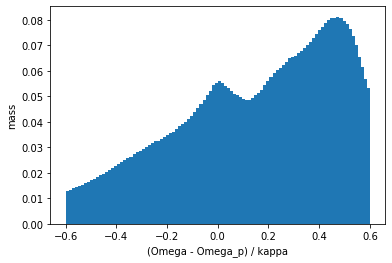

In [16]:
Omega_p = 36.93078876947825
plt.hist((Omega - Omega_p) / kappa, bins=100, weights=mass_bar, range=(-0.6, 0.6))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [17]:
Lz500 = my_mult(mass_halo, np.cross(pos_halo, vel_halo))
Lz300 = my_mult(mass_halo300, np.cross(pos_halo300, vel_halo300))
dLz500 = Lz500 - Lz300

1.2068634582145971e-06


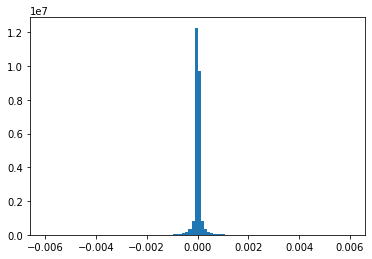

In [38]:
plt.hist(dLz500[:,2], bins=100)
mean = np.mean(dLz500)
print(mean)
mean = 0
std = np.std(dLz500)
key = np.where(np.abs(dLz500 - mean)/std > 6)[0]
plt.show()

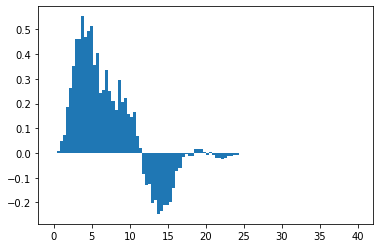

In [43]:
R300 = np.linalg.norm(pos_halo300[:,:2], axis=1)
plt.hist(R300[key], bins=100, range=[0, 40], weights=dLz500[key][:,2])
plt.show()

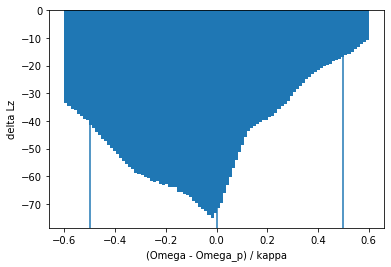

In [18]:
Omega_p = 36.93078876947825
plt.hist((Omega - Omega_p) / kappa, weights=dLz500[:,2], bins=100, range=(-0.6, 0.6))
# plt.xlim(-1, 1)
plt.axvline(0.5)
plt.axvline(0)
plt.axvline(-0.5)
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('delta Lz')
plt.show()

In [19]:
pos_bar625, vel_bar625, mass_bar625, pos_halo625, vel_halo625, mass_halo625 = get_pos_vel_mass_halo_bulge(sn625)

In [20]:
pot_halo625 = agama.Potential(type="Multipole", particles=(pos_halo625, mass_halo625),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar625  = agama.Potential(type="CylSpline", particles=(pos_bar625, mass_bar625),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_tot625 = agama.Potential(pot_halo625, pot_bar625)

In [21]:
R = np.linalg.norm(pos_bar625[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappa625 = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
Omega625 = np.sqrt(-force[:,0]/R)

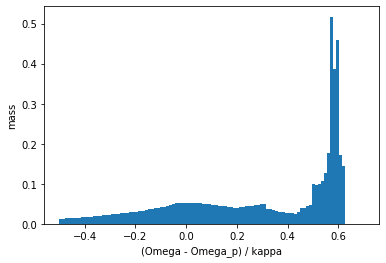

In [22]:
Omega_p = 31.536139084337588
plt.hist((Omega625 - Omega_p) / kappa625, bins=100, weights=mass_bar625, range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [23]:
Lz500 = my_mult(mass_bar, np.cross(pos_bar, vel_bar))
Lz625 = my_mult(mass_bar625, np.cross(pos_bar625, vel_bar625))
dLz625 = Lz625 - Lz500

In [24]:
Lz575 = my_mult(mass_bar575, np.cross(pos_bar575, vel_bar575))
Lz625 = my_mult(mass_bar625, np.cross(pos_bar625, vel_bar625))
dLz625 = Lz625 - Lz575

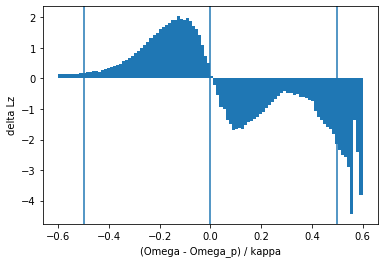

In [25]:
Omega_p = 35
plt.hist((Omega625 - Omega_p) / kappa625, weights=dLz625[:,2], bins=100, range=(-0.6, 0.6))
# plt.xlim(-1, 1)
plt.axvline(0.5)
plt.axvline(0)
plt.axvline(-0.5)
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('delta Lz')
plt.show()

In [26]:
R = np.linalg.norm(pos_halo625[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappa625_halo = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
Omega625_halo = np.sqrt(-force[:,0]/R)

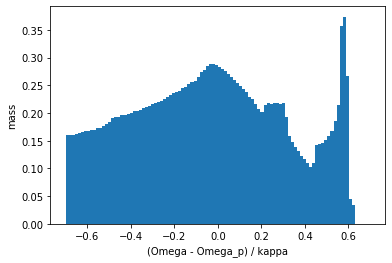

In [27]:
Omega_p = 31.536139084337588
plt.hist((Omega625_halo - Omega_p) / kappa625_halo, bins=100, weights=mass_halo625, range=(-0.7, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [28]:
Lz575 = my_mult(mass_halo575, np.cross(pos_halo575, vel_halo575))
Lz625 = my_mult(mass_halo625, np.cross(pos_halo625, vel_halo625))
dLz625_halo = Lz625 - Lz575

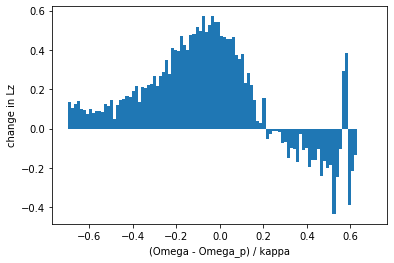

In [29]:
Omega_p = 31.536139084337588
plt.hist((Omega625_halo - Omega_p) / kappa625_halo, bins=100, weights=dLz625_halo[:,2], range=(-0.7, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('change in Lz')
# plt.xlim(-1, 1)
plt.show()

## Redo the same calc but with gas now

In [98]:
snS500 = read_snap(500, 1, parttype=None)
snS450 = read_snap(450, 0, parttype=None)

In [114]:
pos_barS500, vel_barS500, mass_barS500, pos_haloS500, vel_haloS500, mass_haloS500 = \
  get_pos_vel_mass_halo_bulge(snS500, gas=True, center=np.array([200., 200., 200.]))

In [115]:
pos_barS500_ng, vel_barS500_ng, mass_barS500_ng, pos_haloS500_ng, vel_haloS500_ng, mass_haloS500_ng = \
  get_pos_vel_mass_halo_bulge(snS500, gas=False, center=np.array([200., 200., 200.]))
    
pos_barS450_ng, vel_barS450_ng, mass_barS450_ng, pos_haloS450_ng, vel_haloS450_ng, mass_haloS450_ng = \
  get_pos_vel_mass_halo_bulge(snS450, gas=False, center=np.array([200., 200., 200.]))

In [116]:
pot_haloS500 = agama.Potential(type="Multipole", particles=(pos_haloS500, mass_haloS500),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_barS500  = agama.Potential(type="CylSpline", particles=(pos_barS500, mass_barS500),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_totS500 = agama.Potential(pot_haloS500, pot_barS500)

In [117]:
R = np.linalg.norm(pos_barS500_ng[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappaS500 = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
OmegaS500 = np.sqrt(-force[:,0]/R)

In [118]:
R = np.linalg.norm(pos_haloS500_ng[:,:2], axis=1)
points = np.column_stack((R, R*0, R*0))
force,deriv = pot_tot625.forceDeriv(points)
kappaS500_halo = np.sqrt(-deriv[:,0] - 3*force[:,0]/R)
OmegaS500_halo = np.sqrt(-force[:,0]/R)

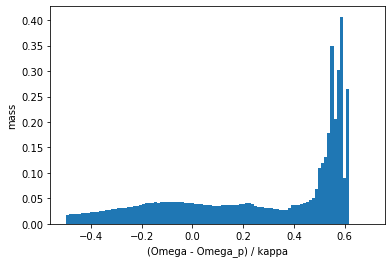

In [121]:
Omega_p = 38
plt.hist((OmegaS500 - Omega_p) / kappaS500, bins=100, weights=mass_barS500_ng, range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

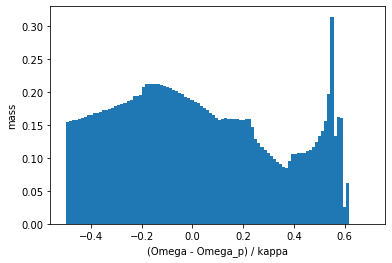

In [120]:
Omega_p = 38
plt.hist((OmegaS500_halo - Omega_p) / kappaS500_halo, bins=100, weights=mass_haloS500_ng, range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('mass')
# plt.xlim(-1, 1)
plt.show()

In [122]:
LzS500 = my_mult(mass_barS500_ng, np.cross(pos_barS500_ng, vel_barS500_ng))
LzS450 = my_mult(mass_barS450_ng, np.cross(pos_barS450_ng, vel_barS450_ng))
dLzS500 = LzS500 - LzS450

LzS500 = my_mult(mass_haloS500_ng, np.cross(pos_haloS500_ng, vel_haloS500_ng))
LzS450 = my_mult(mass_haloS450_ng, np.cross(pos_haloS450_ng, vel_haloS450_ng))
dLzS500_halo = LzS500 - LzS450

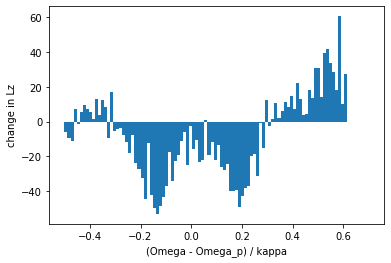

In [124]:
Omega_p = 38
plt.hist((OmegaS500 - Omega_p) / kappaS500, bins=100, weights=dLzS500[:,2], range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('change in Lz')
# plt.xlim(-1, 1)
plt.show()

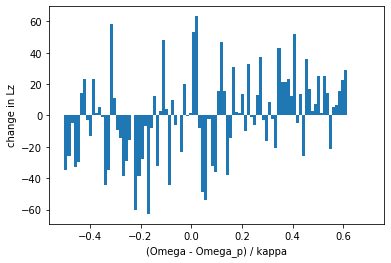

In [129]:
Omega_p = 38
plt.hist((OmegaS500_halo - Omega_p) / kappaS500_halo, bins=100, weights=dLzS500_halo[:,2], range=(-0.5, 0.7))
plt.xlabel('(Omega - Omega_p) / kappa')
plt.ylabel('change in Lz')
# plt.xlim(-1, 1)
plt.show()

## Superfreq Analysis

In [4]:
from superfreq import SuperFreq, closest_resonance
import glob

name = 'Nbody'
lvl = 'lvl4'

phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
nchunk = len(glob.glob(phase_space_path + '/' + name + '-' + lvl + '/phase_space_*'))

i = 0
ps = h5.File(phase_space_path + '/' + name + '-' + lvl + '/phase_space_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')

In [55]:
t = ps['Time']

In [120]:
j = 1001
# center = np.array([200., 200., 200.])
center = np.array([0., 0., 0.])
w = np.hstack((ps['PartType2/Coordinates'][:,j,:] - center, ps['PartType2/Velocities'][:,j,:]))

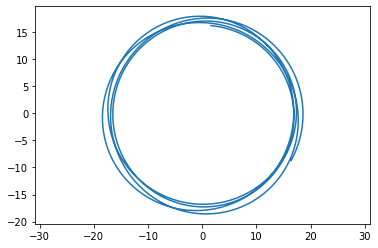

In [121]:
plt.plot(w[:400,0], w[:400,1])
plt.axis('equal')
plt.show()

[110.98677431 111.01077784 110.93600405 ... 112.41203645 112.21342153
 111.99402075]


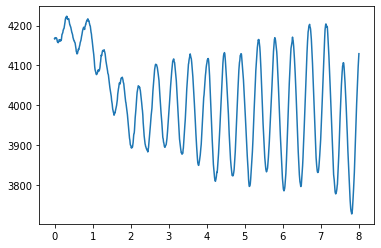

In [72]:
Lz = np.cross(w[:,:3], w[:,3:])[:,2]
R = np.linalg.norm(w[:,:2])
vphi = Lz/R
Tphi = R/vphi
print(Tphi)

plt.plot(t[:], Lz)
plt.show()

In [ ]:
plt.

In [156]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'
nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))

Omega = np.array([]).reshape((0, 3))
snap = 500
print(nchunk)

for i in tqdm(range(nchunk)):
    
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    
    Omega = np.concatenate((Omega, frq['PartType1/Frequencies'][:,snap,:]))

512


A Jupyter Widget

## Direct frequency calc

In [3]:
import glob
def read_chunk(freq_path, name, lvl, i, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    ans = np.array(frq['PartType1/Frequencies'][:,snap,:])
    frq.close()
    return ans

In [8]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

name = 'phantom-vacuum-Sg20-Rc3.5'
lvl='lvl3'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 32

# Omega_S = np.array([]).reshape((0, 3))
snap = np.array([100, 300, 500])
print(nchunk)
# nchunk = 512

out = Parallel(n_jobs=nproc, verbose=10) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_S = np.concatenate(out)

1024


A Jupyter Widget

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:    3.9s
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:   11.8s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:   13.4s
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:   20.3s
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   28.6s
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed:   42.7s
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed:   54.5s
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=32)]: Done 249 tasks      | elapsed:  1.6min
[Parallel(n_jobs=32)]: Done 274 tasks      | elapsed:  

In [10]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

name = 'Nbody'
lvl='lvl3'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 32

snap = np.array([500, 700, 900])
print(nchunk)

out = Parallel(n_jobs=nproc, prefer='threads', verbose=10) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_N = np.concatenate(out)

1024


A Jupyter Widget

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


KeyboardInterrupt: 

3823111
3814254
3809348


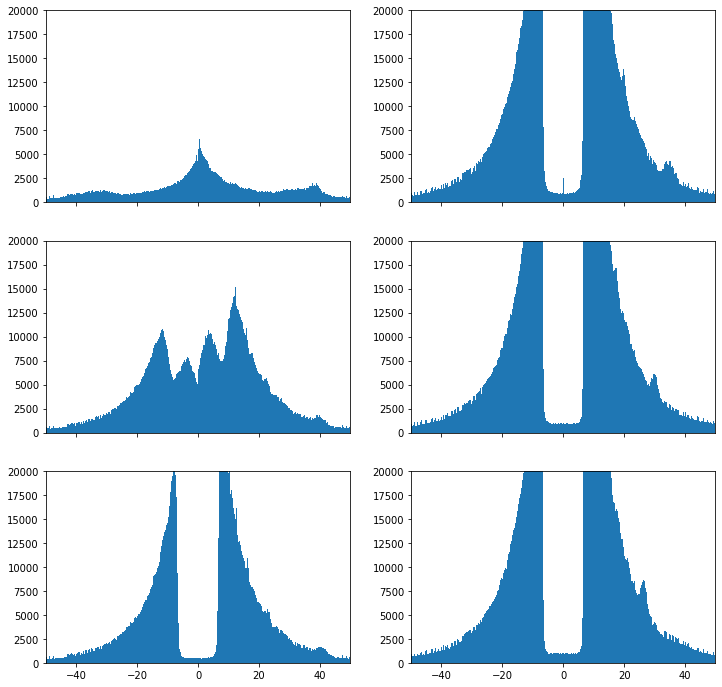

In [62]:
# Omega_p = 40.0

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(12, 12))

rng = (-50, 50)
bins = 800

for i in range(3):
    key = np.where(np.logical_and(Omega_S[:,i,1] > -50, Omega_S[:,i,1] < 50))[0]
    print(len(key))

ax[0][0].hist(Omega_S[:,0,1], bins=bins, range=rng)
ax[1][0].hist(Omega_S[:,1,1], bins=bins, range=rng)
ax[2][0].hist(Omega_S[:,2,1], bins=bins, range=rng)

ax[0][1].hist(Omega_N[:,0,1], bins=bins, range=rng)
ax[1][1].hist(Omega_N[:,1,1], bins=bins, range=rng)
ax[2][1].hist(Omega_N[:,2,1], bins=bins, range=rng)

for x in ax.ravel():
    x.set(xlim=rng, ylim=(0, 20000))

plt.show()

3823111
3814254
3809348


/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


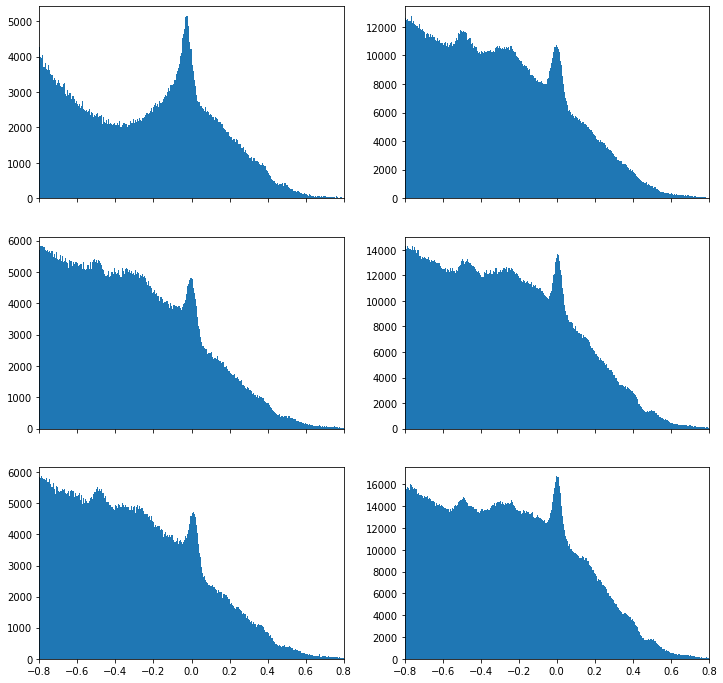

In [81]:
Omega_p = 40.0

#Nbody pattern speeds
Omega_p0 = 35
Omega_p1 = 30
Omega_p2 = 26.5

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(12, 12))

rng = (-0.8, 0.8)
bins = 300

for i in range(3):
    key = np.where(np.logical_and(Omega_S[:,i,1] > -50, Omega_S[:,i,1] < 50))[0]
    print(len(key))
    
y0 = (Omega_S[:,0,1] - Omega_p)/Omega_S[:,0,0]
y1 = (Omega_S[:,1,1] - Omega_p)/Omega_S[:,1,0]
y2 = (Omega_S[:,2,1] - Omega_p)/Omega_S[:,2,0]

yN0 = (Omega_N[:,0,1] - Omega_p0)/Omega_N[:,0,0]
yN1 = (Omega_N[:,1,1] - Omega_p1)/Omega_N[:,1,0]
yN2 = (Omega_N[:,2,1] - Omega_p2)/Omega_N[:,2,0]

ax[0][0].hist(y0, bins=bins, range=rng)
ax[1][0].hist(y1, bins=bins, range=rng)
ax[2][0].hist(y2, bins=bins, range=rng)

ax[0][1].hist(yN0, bins=bins, range=rng)
ax[1][1].hist(yN1, bins=bins, range=rng)
ax[2][1].hist(yN2, bins=bins, range=rng)

# ax[0][1].hist(Omega_N[:,0,1], bins=bins, range=rng)
# ax[1][1].hist(Omega_N[:,1,1], bins=bins, range=rng)
# ax[2][1].hist(Omega_N[:,2,1], bins=bins, range=rng)

for x in ax.ravel():
    x.set(xlim=rng)

plt.show()

In [61]:
len(Omega_S[:,i,1])

12674048

In [22]:
sn0 = read_snap(500, 0, parttype=[1])
sn1 = read_snap(700, 0, parttype=[1])

key0 = np.argsort(sn0.part1.id)
key1 = np.argsort(sn1.part1.id)

pos0 = sn0.part1.pos.value[key0]
pos1 = sn1.part1.pos.value[key1]

vel0 = sn0.part1.vel.value[key0]
vel1 = sn1.part1.vel.value[key1]

mass = sn0.MassTable[1].value

Lz0 = mass * np.cross(pos0, vel0)[:,2]
Lz1 = mass * np.cross(pos1, vel1)[:,2]
dLzN = Lz1 - Lz0

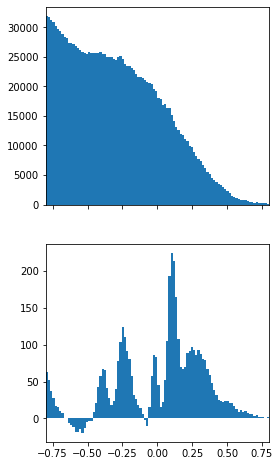

In [108]:
Omega_p = 40.0

#Nbody pattern speeds
Omega_p0 = 35
Omega_p1 = 30
Omega_p2 = 26.5

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(4, 8))
    
yN0 = (-Omega_N[:,0,1] - Omega_p0)/Omega_N[:,0,0]
rng = (-0.8, 0.8)
bins=100
bin_width = (rng[1]-rng[0])/bins

# yN0 = Omega_N[:,0,1]
# rng = (-50, 50)

ax[0].hist(yN0, bins=bins, range=rng)
ax[1].hist(yN0, bins=bins, range=rng, weights=dLzN/bin_width)

for x in ax.ravel():
    x.set(xlim=rng)

plt.show()

In [104]:
np.sum(dLzN[np.logical_and(yN0>-0.8, yN0 < 0.8)])

66.24580052750066

In [105]:
dLzN[np.logical_and(yN0>-0.8, yN0 < 0.8)]

array([-1.94599360e-04,  1.07030479e-04, -1.78422594e-05, ...,
        3.23821900e-03,  1.12177378e-04,  5.11774196e-04])

In [28]:
sn0 = read_snap(500, 1, parttype=[1])
sn1 = read_snap(700, 1, parttype=[1])

center = np.array([200., 200., 200.])

key0 = np.argsort(sn0.part1.id)
key1 = np.argsort(sn1.part1.id)

pos0 = sn0.part1.pos.value[key0] - center
pos1 = sn1.part1.pos.value[key1] - center

vel0 = sn0.part1.vel.value[key0]
vel1 = sn1.part1.vel.value[key1]

mass = sn0.MassTable[1].value

Lz0 = mass * np.cross(pos0, vel0)[:,2]
Lz1 = mass * np.cross(pos1, vel1)[:,2]
dLz2 = Lz1 - Lz0



sn0 = read_snap(100, 1, parttype=[1])
sn1 = read_snap(300, 1, parttype=[1])

center = np.array([200., 200., 200.])

key0 = np.argsort(sn0.part1.id)
key1 = np.argsort(sn1.part1.id)

pos0 = sn0.part1.pos.value[key0] - center
pos1 = sn1.part1.pos.value[key1] - center

vel0 = sn0.part1.vel.value[key0]
vel1 = sn1.part1.vel.value[key1]

mass = sn0.MassTable[1].value

Lz0 = mass * np.cross(pos0, vel0)[:,2]
Lz1 = mass * np.cross(pos1, vel1)[:,2]
dLz0 = Lz1 - Lz0

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


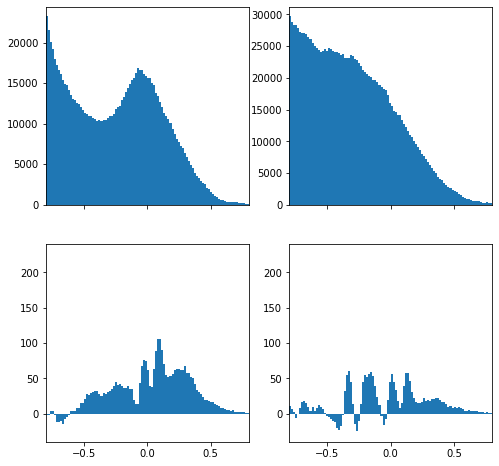

In [43]:
Omega_p = 40.0

#Nbody pattern speeds
Omega_p0 = 35
Omega_p1 = 30
Omega_p2 = 26.5

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
    
i=0
bins=100
y0 = (-Omega_S[:,0,1] - Omega_p)/Omega_S[:,0,0]
y2 = (-Omega_S[:,2,1] - Omega_p)/Omega_S[:,2,0]
rng = (-0.8, 0.8)
bin_width = (rng[1]-rng[0])/bins

# yN0 = Omega_N[:,0,1]
# rng = (-50, 50)

ax[0][0].hist(y0, bins=bins, range=rng)
ax[1][0].hist(y0, bins=bins, range=rng, weights=dLz0/bin_width)

ax[0][1].hist(y2, bins=bins, range=rng)
ax[1][1].hist(y2, bins=bins, range=rng, weights=dLz2/bin_width)

ax[1][0].set(ylim=(-40, 240))
ax[1][1].set(ylim=(-40, 240))

for x in ax.ravel():
    x.set(xlim=rng)

plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(25347840,) (25347840,)


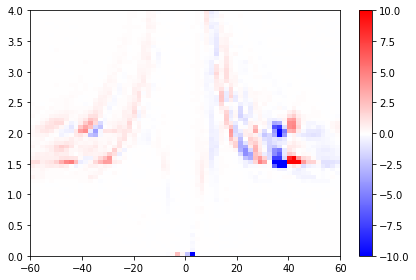

In [45]:
from scipy.ndimage import gaussian_filter
nres = 64

range_xy = [[-60, 60], [0, 4]]

i=0

x = Omega_S[:,i,1]
y = Omega_S[:,i,0]/np.abs(Omega_S[:,i,1])
print(np.shape(x), np.shape(y))

bin_area = ((range_xy[0][1]-range_xy[0][0])*(range_xy[1][1]-range_xy[1][0]))/nres/nres

heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=dLz0/bin_area)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

# heatmap_xy = gaussian_filter(heatmap_xy, sigma=0.1)

fig, ax = plt.subplots(1, 1)

# heatmap_xy[heatmap_xy==0.0] = 0.1

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-10, vmax=10)
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)
fig.tight_layout()

plt.show()


/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


(25347840,) (25347840,)


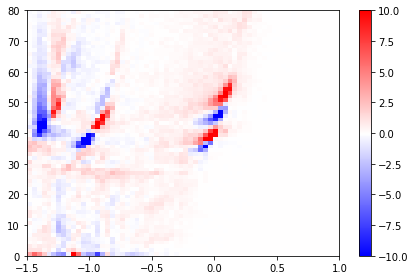

In [48]:
from scipy.ndimage import gaussian_filter
nres = 64

range_xy = [[-1.5, 1], [0, 80]]

i=0

x = (-Omega_S[:,0,1] - Omega_p)/Omega_S[:,0,0]
y = Omega_S[:,i,2]
print(np.shape(x), np.shape(y))

bin_area = ((range_xy[0][1]-range_xy[0][0])*(range_xy[1][1]-range_xy[1][0]))/nres/nres

heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=dLz0/bin_area)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

# heatmap_xy = gaussian_filter(heatmap_xy, sigma=0.1)

fig, ax = plt.subplots(1, 1)

# heatmap_xy[heatmap_xy==0.0] = 0.1

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-10, vmax=10)
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)
fig.tight_layout()

plt.show()


In [23]:
print(np.sum(dLzN))

85.0861087204858


## Fourier Transform

In [3]:
import glob

name = 'phantom-vacuum-Sg20-Rc3.5'
lvl = 'lvl3'

phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
nchunk = len(glob.glob(phase_space_path + '/' + name + '-' + lvl + '/phase_space_*'))

i = 0
ps = h5.File(phase_space_path + '/' + name + '-' + lvl + '/phase_space_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')

In [59]:
pos_bar, vel_bar, mass_bar, pos_halo, vel_halo, mass_halo = \
        get_pos_vel_mass_halo_bulge(snS, gas=True, center=np.array([200., 200., 200.]))

In [4]:
j = 1001
center = np.array([200., 200., 200.])
pos = ps['PartType2']['Coordinates'][:,:,:] - center
vel = ps['PartType2']['Velocities'][:,:,:]
w = np.hstack((pos, vel))

In [60]:
pot_halo_S = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar_S  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar),
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot_tot_S = agama.Potential(pot_halo_S, pot_bar_S)

In [5]:
R = np.linalg.norm(w[:,:,:2], axis=2)
phi = np.arctan2(w[:,:,1], w[:,:,0])
z = w[:,:,2]

# vR = 


In [6]:
time = ps['Time'][:]
dt = (time[-1]-time[0])/(len(time)-1)
print(dt)

0.0050031269543464665


In [7]:
start = 400
end = 1200

ftR = np.fft.rfft(R[start:end,:], axis=0)
k = np.fft.rfftfreq(len(R[start:end,:]), dt)
print(len(R[600:1000,:]))
PR = np.abs(ftR)**2

400


In [8]:
ftR.shape

(401, 12588)

In [9]:
k.shape

(401,)

In [10]:
np.fft.rfftfreq(100).shape

(51,)

In [11]:
freq = k[np.argsort(PR, axis=0)[-2]]

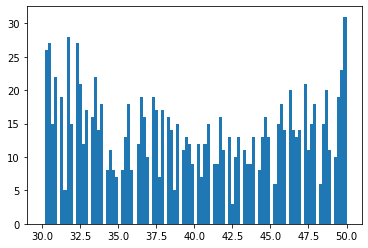

In [12]:
plt.hist(freq, bins=100, range=(30, 50))
plt.show()

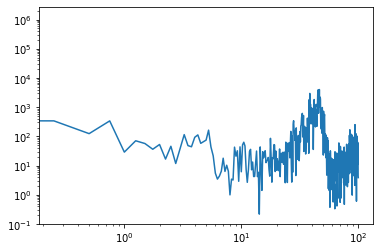

In [45]:
plt.plot(k, PR[:,0])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [14]:
ftphi = np.fft.rfft(phi[start:end], axis=0)
k = np.fft.rfftfreq(len(phi[start:end]), dt)
Pphi = np.abs(ftphi)**2

In [50]:
freq_phi = k[np.argsort(Pphi, axis=0)[-2]]
freq_phi[5]

54.965625

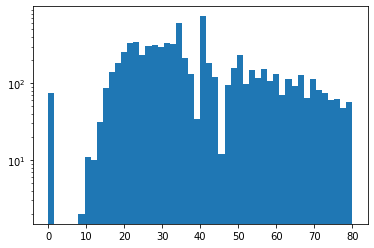

In [52]:
plt.hist(2.*np.pi*freq_phi, bins=50, range=(0, 80))
plt.yscale('log')
# plt.xscale('log')
plt.show()

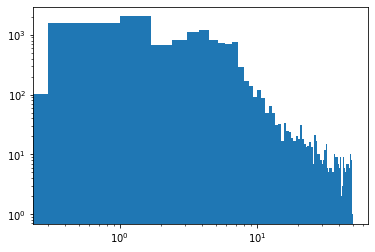

In [54]:
plt.hist(freq_phi - 0.5 * freq, bins=100, range=(-20, 50))
plt.yscale('log')
plt.xscale('log')
plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


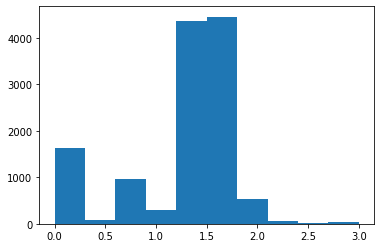

In [18]:
plt.hist(freq/freq_phi, range=(0, 3))
plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


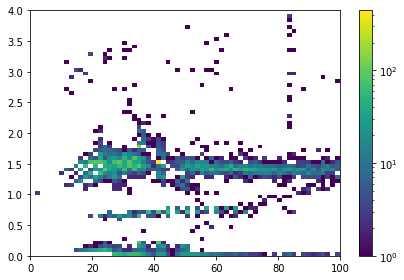

In [19]:
from scipy.ndimage import gaussian_filter
nres = 64

range_xy = [[0, 100], [0, 4]]

x = 2.*np.pi*freq_phi
y = freq/freq_phi
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

# heatmap_xy = gaussian_filter(heatmap_xy, sigma=0.1)

fig, ax = plt.subplots(1, 1)

# heatmap_xy[heatmap_xy==0.0] = 0.1

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)
fig.tight_layout()

plt.show()


In [ ]:
k[161]

In [ ]:
np.max(heatmap_xy)

In [ ]:
phi_bool = np.abs(2.*np.pi*freq_phi - 40.1) < 0.75
R_bool = (freq/freq_phi - 1.5) < 0.01

key = np.where(np.logical_and(phi_bool, R_bool))[0]
print(len(key))

In [ ]:
from scipy.ndimage import gaussian_filter
nres = 64

range_xy = [[-10,10], [-10,10]]

x = w[800,:,0][key]
y = w[800,:,1][key]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

# heatmap_xy = gaussian_filter(heatmap_xy, sigma=0.1)

fig, ax = plt.subplots(1, 1)

# heatmap_xy[heatmap_xy==0.0] = 0.1

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
fig.colorbar(im, ax=ax)
fig.tight_layout()

plt.show()


In [306]:
import glob

name = 'Nbody'
lvl = 'lvl3'

phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
nchunk = len(glob.glob(phase_space_path + '/' + name + '-' + lvl + '/phase_space_*'))

i = 0
psN = h5.File(phase_space_path + '/' + name + '-' + lvl + '/phase_space_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')

In [307]:
j = 1001
center = np.array([0., 0., 0.])
posN = ps['PartType1']['Coordinates'][:,:,:] - center
velN = ps['PartType1']['Velocities'][:,:,:]
wN = np.hstack((posN, velN))

In [397]:
def read_chunk(freq_path, name, lvl, i, center=np.array([200., 200., 200.])):
    ps = h5.File(freq_path + '/' + name + '-' + lvl + '/phase_space_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    pos = np.array(ps['PartType2/Coordinates']) - center
    vel = np.array(ps['PartType2/Velocities'])
    w = np.hstack((pos, vel))
    return w

In [ ]:
phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'

name = 'phantom-vacuum-Sg20-Rc3.5'
lvl='lvl3'

nchunk = len(glob.glob(phase_space_path + '/' + name + '-' + lvl + '/phase_space_*'))
nchunk = 64
nproc = 32

# out = Parallel(n_jobs=nproc) (delayed(read_chunk)(phase_space_path, name, lvl, i) for i in tqdm(range(nchunk)))
out = [read_chunk(phase_space_path, name, lvl, i) for i in tqdm(range(nchunk))]
w = np.concatenate(out)

A Jupyter Widget

## FT Analysis

In [28]:
def read_chunk(freq_path, name, lvl, i, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')
    omegaR = np.array(frq['PartType1/OmegaR'])
    omegaPhi = np.array(frq['PartType1/OmegaPhi'])
    omegaZ = np.array(frq['PartType1/OmegaZ'])
    ans = np.transpose([omegaR, omegaPhi, omegaZ])
    
    frq.close()
    return ans

In [30]:
freq_path = '/n/home01/abeane/starbar/plots/freq2/data'

name = 'Nbody'
lvl='lvl4'

nchunk = len(glob.glob(freq_path + '/freq_' + name + '-' + lvl + '/freq_*'))
nproc = 32

snap = 500
print(nchunk)

out = Parallel(n_jobs=nproc) (delayed(read_chunk)(freq_path, name, lvl, i, snap) for i in tqdm(range(nchunk)))
Omega_N = np.concatenate(out)

512


A Jupyter Widget

In [55]:
Omega_N[1,:,2]

array([1., 3., 1., 3., 1., 1., 2., 2., 3., 2., 3., 2., 2., 0., 1., 2., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [56]:
i = 0
frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(i)+'.hdf5', mode='r')

In [76]:
frq['PartType1/OmegaPhi'][:,27]

array([1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 2., 1., 2., 2., 2., 2., 2.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 2., 1., 2.])

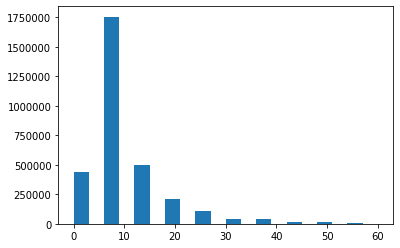

In [84]:
plt.hist(2.*np.pi*Omega_N[:,15,1], range=(0, 60), bins=20)
plt.show()

In [87]:
2.*np.pi*np.fft.rfftfreq(400, 0.005)

array([  0.        ,   3.14159265,   6.28318531,   9.42477796,
        12.56637061,  15.70796327,  18.84955592,  21.99114858,
        25.13274123,  28.27433388,  31.41592654,  34.55751919,
        37.69911184,  40.8407045 ,  43.98229715,  47.1238898 ,
        50.26548246,  53.40707511,  56.54866776,  59.69026042,
        62.83185307,  65.97344573,  69.11503838,  72.25663103,
        75.39822369,  78.53981634,  81.68140899,  84.82300165,
        87.9645943 ,  91.10618695,  94.24777961,  97.38937226,
       100.53096491, 103.67255757, 106.81415022, 109.95574288,
       113.09733553, 116.23892818, 119.38052084, 122.52211349,
       125.66370614, 128.8052988 , 131.94689145, 135.0884841 ,
       138.23007676, 141.37166941, 144.51326207, 147.65485472,
       150.79644737, 153.93804003, 157.07963268, 160.22122533,
       163.36281799, 166.50441064, 169.64600329, 172.78759595,
       175.9291886 , 179.07078125, 182.21237391, 185.35396656,
       188.49555922, 191.63715187, 194.77874452, 197.92

In [ ]:
print(1)